## <center>An inverse model for inferring surface fluxes and mixing from gridded hydrographic TS data, <br> by Taimoor Sohail and Jan D. Zika


##### <center>We use an optimal transport method, minimzing a cost function which respects the volume and mass conservation, and the fundamental physics of mixing in T-S space. <br>See also: Jan D Zika et al. (2021) [www.doi.org/10.1175/JCLI-D-20-0355.1 ] for a simpler version of this model which optimizes ocean circulation only.
------------

### __The code is laid out as follows:__
#### A) Pre-processing
i) Load necessary modules for computation \
ii) Define key parameters
#### B) Load Data
#### C) Define constraints
i) Define Connectivity \
ii) Define weights
#### D) Run optimisation
#### E) Save Output
---------

## A) Pre-processing

### i) Load necessary modules for computation

In [2]:
## Module to run the minimisation
from WM_Methods import MTM
## The linear optimisation module
import cvxpy as cp 
## Module to track runtime of cells and loops
import time
from tqdm.notebook import tqdm
## Suppress warnings related to division by zero
import warnings
warnings.filterwarnings('ignore')
## Module to load files and handle array computations
import xarray as xr
import numpy as np
## Modules to plot outputs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### ii) Define key parameters

In [3]:
# Specifying the number of BSP bins, 2^n
tree_depth = 4

In [4]:
volnorming = 10**15 #normalising coeffcients
areanorming = 10**12 #normalising coeffcients

# Establish basic constants 
yr2sec = 365.25*24*60*60
# delta(time) in the ACCESS-CM2 model
dt_OG = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/dtime*.nc').sel(time=slice('1979-01-01',None))
dt_OG['time'] = np.arange(dt_OG.average_DT.size).astype(float)
dt = dt_OG.rename({'time':'Time'})
# Reference density, specific heat capacity and reference salinity
rho = 1035 #kg/m^3
Cp = 3992.10322329649
S0=35

# Range of years over which 'early' and 'late' are defined
dyrs = 9
# Start and end year
init_early = 1979
init_late = 2006
Early_period = (np.array([init_early,init_early+dyrs]) - init_early)*12#+((-1979)*12)
Late_period = (np.array([init_late,init_late+dyrs]) - init_early)*12#+((-1979)*12)
range_yrs = init_late-init_early+1

-----------
## B) Load Data



The data is presented as monthly T-S observations from EN4, from January 1970 to December 2014. The observations have already been binned via Binary Space Partitioning according to a specific criterion. Folowing Sohail et al. (TBD) the BSP partitioning occurs in an xyxyxyx order, shown to minimize variability in the temperature and salinity signals. 



In [26]:
%%time
# Load ACCESS-CM2 data (this data has already been coarsened into basins and BSP bins)
ACCESS_BSP_data = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/*ACCESS_ERA5_*%i_bins_*.nc' %(tree_depth))


## Early Period
Part_early = ACCESS_BSP_data.Partitions.isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
SA_early =  ACCESS_BSP_data.S_mean.isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
CT_early = (ACCESS_BSP_data.T_mean-273.15).isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
V_early = ACCESS_BSP_data.V_sum.isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
A_early = ACCESS_BSP_data.A_sum.isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
CTV_early = ((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
SAV_early = (ACCESS_BSP_data.S_mean*ACCESS_BSP_data.V_sum).isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])

## Late Period
Part_late = ACCESS_BSP_data.Partitions.isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])
SA_late =  ACCESS_BSP_data.S_mean.isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])
CT_late = (ACCESS_BSP_data.T_mean-273.15).isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])-273.15
V_late = ACCESS_BSP_data.V_sum.isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])
A_late = ACCESS_BSP_data.A_sum.isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])
CTV_late = ((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])
SAV_late = (ACCESS_BSP_data.S_mean*ACCESS_BSP_data.V_sum).isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])

Basins = ACCESS_BSP_data.Basin.values

CPU times: user 287 ms, sys: 12.4 ms, total: 300 ms
Wall time: 504 ms


In [7]:
%%time
## Load the volumetric distribution (in T-S space) of the ACCESS-CM2 model [for figure 3]
ACCESS_TS_dist_hist = xr.open_mfdataset('~/UNSW_work/MIN_MIX_FINAL/TS_Sfunction/TS_distribution_ACCESS_CM2_hist.nc')
# Define T; S bin limits
tbins = ACCESS_TS_dist_hist.tbins.values
sbins = ACCESS_TS_dist_hist.sbins.values
dtbins = np.diff(tbins)[0]
dsbins = np.diff(sbins)[0]

CPU times: user 11.1 ms, sys: 3.33 ms, total: 14.4 ms
Wall time: 14.8 ms


##### Calculate the T and S standard deviations, $\sigma_T; \sigma_S$, for weights $w_j$

In [8]:
## Remove NaNs to calculate standard deviation
T_nonan = ACCESS_TS_dist_hist.tbins.expand_dims(dim={"sbins": ACCESS_TS_dist_hist.sbins.size, "time":ACCESS_TS_dist_hist.time.size}).\
assign_coords({"sbins": ACCESS_TS_dist_hist.sbins, "time":ACCESS_TS_dist_hist.time})*(ACCESS_TS_dist_hist.TS_distribution/ACCESS_TS_dist_hist.TS_distribution)
S_nonan = ACCESS_TS_dist_hist.sbins.expand_dims(dim={"tbins": ACCESS_TS_dist_hist.tbins.size, "time":ACCESS_TS_dist_hist.time.size}).\
assign_coords({"tbins": ACCESS_TS_dist_hist.tbins, "time":ACCESS_TS_dist_hist.time})*(ACCESS_TS_dist_hist.TS_distribution/ACCESS_TS_dist_hist.TS_distribution)
# Calculate standard deviation
T_nonan_std = T_nonan.std(skipna=True).values
S_nonan_std = S_nonan.std(skipna=True).values
# Weights are 1/std
T_scale = 1/T_nonan_std
S_scale = 1/S_nonan_std

##### Plot BSP bins and $V_0$, $T_0$ and $S_0$ [Figure 4]

In [9]:
%%time
# Load the early partition values and volumes
Part_early.load()
V_early_vals = np.log10(V_early.values)
V_early_vals[~np.isfinite(V_early_vals)] = 0

# Load the geographical masks, \omega
mask_EN4_xr = xr.open_mfdataset('../Basin_mask/mask_EN4.nc')
mask_EN4 = (mask_EN4_xr.__xarray_dataarray_variable__.isel(depth=0).values)
data = xr.open_mfdataset('~/UNSW_work/EN4_Data/EN_data/EN4_CT_SA_0*')
lats = data.lat.values
lons = data.lon.values

mask_EN4[mask_EN4==0] = np.nan

CPU times: user 1.52 s, sys: 260 ms, total: 1.78 s
Wall time: 2.35 s


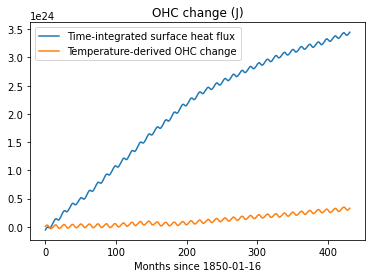

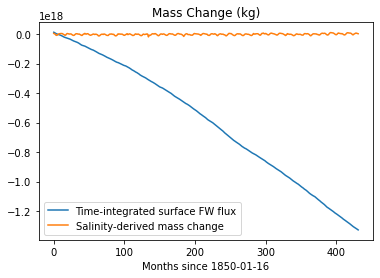

In [10]:
## Check for heat and salt closure
## HEAT
(((ACCESS_BSP_data.hfds_sum)*dt.average_DT).cumsum('Time')-((ACCESS_BSP_data.hfds_sum*dt.average_DT).cumsum('Time').isel(Time=slice(0,12)).mean('Time'))).sum('Basin').sum('Depth').plot(label='Time-integrated surface heat flux')
((rho*Cp*((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum))-(rho*Cp*((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).isel(Time=slice(0,12)).mean('Time'))).sum('Basin').sum('Depth').plot(label='Temperature-derived OHC change')
plt.title('OHC change (J)')
plt.xlabel('Months since 1850-01-16')
# plt.xlim(0,1980)

plt.legend()
# plt.savefig('../Figures/glob_hfds_OHC_closure.png', dpi=300, bbox_inches='tight')
plt.show()
## SALT
(((ACCESS_BSP_data.wfo_sum)*dt.average_DT).cumsum('Time')-((ACCESS_BSP_data.wfo_sum*dt.average_DT).cumsum('Time').isel(Time=slice(0,12)).mean('Time'))).sum('Basin').sum('Depth').plot(label='Time-integrated surface FW flux')
((-ACCESS_BSP_data.S_mean/S0*rho*ACCESS_BSP_data.V_sum)-(-ACCESS_BSP_data.S_mean/S0*rho*ACCESS_BSP_data.V_sum).isel(Time=slice(0,12)).mean('Time')).sum('Basin').sum('Depth').plot(label='Salinity-derived mass change')
plt.title('Mass Change (kg)')
plt.xlabel('Months since 1850-01-16')
plt.legend()
# plt.xlim(0,1980)
# plt.savefig('../Figures/glob_wfo_OSC_closure.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
## Load Q_prior data here
## Calculate the cumulative time integrated surface fluxes 
HFDS_cumsum = (((ACCESS_BSP_data.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=-1))\
    -(((ACCESS_BSP_data.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0])) # units: J
WFO_cumsum = ((ACCESS_BSP_data.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=-1)\
        -(((ACCESS_BSP_data.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0]))# units: kg

## The final dflux value is then scaled by the time between the middle of t1 and the middle of t2
dhfds = HFDS_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
dwfo = WFO_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))

## Convert dflux to equivalent T or S change
dT_prior = (dhfds/(Cp*rho*V_early)).values.flatten() # units: C
dS_prior = (-dwfo*S0/(rho*V_early)).values.flatten() # units: g/kg

time = ACCESS_BSP_data.Time.values

In [13]:

# Flatten the early and late variables to a 1D array
Vol_1 = V_early.values.flatten()
Vol_2 = V_late.values.flatten()
S_1 = SAV_early.values.flatten()/Vol_1-S0 # Remove reference salinity S0
S_2 = SAV_late.values.flatten()/Vol_2-S0 # Remove reference salinity S0
T_1 = CTV_early.values.flatten()/Vol_1
T_2 = CTV_late.values.flatten()/Vol_2
A_1 = A_early.values.flatten()
A_2 = A_late.values.flatten()

# Do the same for basin index
Basin_1 = np.zeros_like(V_early)
Basin_2 = np.zeros_like(V_early)
Basin_names = []
for i in range(np.array(Basins).size):
    Basin_1[i,:] = i
    Basin_2[i,:] = i
    for j in range(V_early.shape[-1]):
        #... and for basin name
        Basin_names.append(Basins[i])

Basin_1_inds = Basin_1.flatten()
Basin_2_inds = Basin_2.flatten()

#... and for the edges of the BSP bins
## Here we calculate the mean TS edges averaged over both early and late times
S_start = (0.5*(Part_early.values[:,:,0]+Part_late.values[:,:,0])).flatten()-S0 # Remove reference salinity S0
S_end = (0.5*(Part_early.values[:,:,1]+Part_late.values[:,:,1])).flatten()-S0 # Remove reference salinity S0
T_start = (0.5*(Part_early.values[:,:,2]+Part_late.values[:,:,2])).flatten()
T_end = (0.5*(Part_early.values[:,:,3]+Part_late.values[:,:,3])).flatten()

# Any NaNs are zeroed out
S_1[np.isnan(S_1)] = 0
S_2[np.isnan(S_2)] = 0
T_1[np.isnan(T_1)] = 0
T_2[np.isnan(T_2)] = 0

In [14]:
## Add the Q_prior to S_0; T_0 to get the 'initial' state ##
S_pre = SAV_early.values.flatten()/Vol_1-S0
S_1 = SAV_early.values.flatten()/Vol_1-S0+dS_prior
T_pre = CTV_early.values.flatten()/Vol_1
T_1 = CTV_early.values.flatten()/Vol_1+dT_prior
S_1[np.isnan(S_1)] = 0
T_1[np.isnan(T_1)] = 0
S_1[~np.isfinite(S_1)] = 0
T_1[~np.isfinite(T_1)] = 0
S_pre[np.isnan(S_pre)] = 0
T_pre[np.isnan(T_pre)] = 0
S_pre[~np.isfinite(S_pre)] = 0
T_pre[~np.isfinite(T_pre)] = 0


In [15]:
## Here, we create the tracers and volumes matrices, which will be fed into the MTM function

volumes = np.stack((Vol_1, Vol_2), axis=0)/volnorming # Shape: [2 x N]

salinities = np.stack((S_1, S_2), axis=0)
temps = np.stack((T_1, T_2), axis=0)

tracers = np.stack((salinities, temps),axis=1) # Shape: [2 x M x N], where M = 2 for just T and S, and M>2 for T,S+other tracers

In [16]:
print('Total number of bins =', int(Vol_1.shape[0]))
N = int(Vol_1.shape[0])

Total number of bins = 144


---------------
## C) Define Constraints

### i) Define Connectivity

We must define whether a BSP bin is allowed to transport volume to another BSP bin. In the simplest case, all bins are allowed to transport to one another - but this yields nonphysical transport across vast distances and TS bounds.
To improve on this, two connectivity constraints are used: 
1) Are the basins adjacent? This is defined via the connectivity array, below
2) If YES, do the BSP bins have overlapping (or the same) TS boundaries?\
If yes, the bins are connected. If no, they are not.


In [17]:
# Array defining the connection between the 9 basins;
# 1 = connected, 0 = disconnected
# connectivity_array = np.ones((Basins.size,Basins.size))

connectivity_array = np.zeros((Basins.size,Basins.size))

connectivity_array[0,:] = [1, 1, 0, 0, 0, 0, 0, 0, 0]
connectivity_array[1,:] = [1, 1, 1, 0, 0, 0, 0, 0, 0]
connectivity_array[2,:] = [0, 1, 1, 1, 0, 0, 0, 0, 0]
connectivity_array[3,:] = [0, 0, 1, 1, 0, 0, 0, 0, 1]
connectivity_array[4,:] = [0, 0, 0, 0, 1, 0, 1, 0, 1]
connectivity_array[5,:] = [0, 0, 0, 0, 0, 1, 1, 0, 1]
connectivity_array[6,:] = [0, 0, 0, 0, 1, 1, 1, 1, 0]
connectivity_array[7,:] = [0, 0, 0, 0, 0, 0, 1, 1, 0]
connectivity_array[8,:] = [0, 0, 0, 1, 1, 1, 0, 0, 1]

d = {Basins[0]: connectivity_array.T[0,:],\
    Basins[1]: connectivity_array.T[1,:],\
    Basins[2]: connectivity_array.T[2,:],\
    Basins[3]: connectivity_array.T[3,:],\
    Basins[4]: connectivity_array.T[4,:],\
    Basins[5]: connectivity_array.T[5,:],\
    Basins[6]: connectivity_array.T[6,:],\
    Basins[7]: connectivity_array.T[7,:],\
    Basins[8]: connectivity_array.T[8,:]}
    
table = pd.DataFrame(data=d, index=Basins)
table

,Polar N. Atlantic,Subtropical N. Atlantic,Eq. Atlantic,S. Atlantic,Indian,S. Pacific,Eq. Pacific,N. Pacific,Southern Ocean
Polar N. Atlantic,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Subtropical N. Atlantic,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Atlantic,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
S. Atlantic,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
Indian,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
S. Pacific,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
Eq. Pacific,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
N. Pacific,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
Southern Ocean,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [18]:
# Define whether a bin is connected to every other bin
# The two constraints used are: are the basins adjacent? 
# If yes, are the bin indices the same? 
# If yes, the bins are connected; if no, they are not connected. 

# connected = np.ones((Vol_1.size, Vol_1.size)) ## For all connections case

trans_big = np.zeros((Vol_1.size, Vol_1.size))
connected = np.zeros((Vol_1.size, Vol_1.size))

for i in tqdm(range(Vol_1.size)):
    for j in range(Vol_2.size):
        if connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]>0:
            connected[i,j] = 1 ## For NO DOCKING case


  0%|          | 0/144 [00:00<?, ?it/s]

### ii) Define Weights

In [19]:
## We create a weight matrix
# For sqrt(1/Area)
A_2_modified = A_2.copy()
A_2_modified[A_2_modified==0] = 1*10**2.02 # this is the lowest I can make it for tree_depth=4 without it breaking

area_weight = np.sqrt(areanorming/A_2_modified)

area_cons = A_2/A_2-1
area_cons[np.isnan(area_cons)] = 1

weights = np.stack((S_scale*area_weight, T_scale*area_weight), axis=0) # Shape: An [M x N] matrix
hard_area = np.stack((area_cons,area_cons), axis=0)

-----------------
## D) Run Optimisation

In [20]:
## We run the optimiser to get the transports between water masses and the T,S mixed and T,S adjustment
result = MTM.optimise(tracers=tracers, volumes=volumes, cons_matrix = connected, weights=weights, hard_area = hard_area)

g_ij = result['g_ij'] ## An [N x N] matrix of transports between WMs
Mixing = result['Mixing'] ## An [M x N] matrix of dtracer mixing for each WM
Adjustment = result['Adjustment'] ## An [M x N] matrix of dtracer adjustment for each WM
G = result['G'] ## An [ix] matrix of transports between WMs

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Mar 26 12:02:30 PM: Your problem has 6912 variables, 3 constraints, and 0 parameters.
(CVXPY) Mar 26 12:02:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 26 12:02:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 26 12:02:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 26 12:02:30 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Mar 26 12:02:30 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

In [22]:
########
nofaces = np.count_nonzero(connected)


G = np.zeros((int(nofaces)))
ix=0
for i in (range(N)):
    for j in range(N):
        if connected[i,j]>0:
            G[ix] = g_ij[i,j]
            ix=ix+1   


Tmatrix=np.zeros((N,int(nofaces)))
Smatrix=np.zeros((N,int(nofaces)))

ix=0
for i in (range(N)):
    for j in range(N):
        if connected[i,j]>0:
            Tmatrix[j,ix] = tracers[0,1,i] #vertex ix brings temp of WM i to WM j
            Smatrix[j,ix] = tracers[0,0,i] #vertex ix brings temp of WM i to WM j

            ix=ix+1

print(volnorming*np.nansum(volumes[0,:]*T_pre), volnorming*np.nansum(volumes[1,:]*T_2))

dTV = (volumes[1,:]*T_2)-(volumes[0,:]*T_pre)
dTVprior = dT_prior*volumes[0,:]
T1V1 = volumes[1,:]*T_2

dSV = (volumes[1,:]*S_2)-(volumes[0,:]*S_pre)
dSVprior = dS_prior*volumes[0,:]
S1V1 = volumes[1,:]*S_2

test = ((Tmatrix@G/volumes[1,:]))

test[~np.isfinite(test)]= np.nan
test[test>100] = np.nan

test2  = T_2 - test
test2[np.isnan(test2)] = 0

print('dTV_adj = ',np.nansum(T1V1*volnorming-Tmatrix@G*volnorming))
print('T1V1-T0V0 = ',np.nansum(dTV)*volnorming)
print('dTpriorV0 = ',np.nansum(dTVprior)*volnorming)
print('-(T1V1-T0V0)+dTV_adj+dTpriorV0 [x10^10]= ',(-np.nansum(dTV)*volnorming+np.nansum(dTVprior)*volnorming+np.nansum(T1V1*volnorming-Tmatrix@G*volnorming))*1e-10)

print('dSV_adj = ',np.nansum(S1V1*volnorming-Smatrix@G*volnorming))
print('S1V1-S0V0 = ',np.nansum(dSV)*volnorming)
print('dSpriorV0 = ',np.nansum(dSVprior)*volnorming)
print('-(S1V1-S0V0)+dSV_adj+dSpriorV0 [x10^10]= ',(-np.nansum(dSV)*volnorming+np.nansum(dSVprior)*volnorming+np.nansum(S1V1*volnorming-Smatrix@G*volnorming))*1e-10)

6.364637623924389e+18 6.424345102791803e+18
dTV_adj =  -5.756991003089268e+17
T1V1-T0V0 =  5.970747886741381e+16
dTpriorV0 =  6.354066001244215e+17
-(T1V1-T0V0)+dTV_adj+dTpriorV0 [x10^10]=  2.0948080896
dSV_adj =  -3.408768257397696e+16
S1V1-S0V0 =  -74880361090825.75
dSpriorV0 =  3.4012801040534924e+16
-(S1V1-S0V0)+dSV_adj+dSpriorV0 [x10^10]=  -0.1172351212


In [ ]:
## Break down the Mixing and Adjustment matrices into their constituent tracers
dT_mixing = Mixing[1,:]
dS_mixing = Mixing[0,:]
dS_adj = Adjustment[0,:]
dT_adj = Adjustment[1,:]

----------
## E) Save Output 

In [ ]:
file_path = '../Optimisation_results/ACCESS_CM2_ERA5_Q_prior_transports.nc'

In [ ]:
import os
if os.path.exists(file_path):
   os.remove(file_path)
   print('File deleted')

da_dT_mixing = xr.DataArray(data = dT_mixing, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Temperature Mixing", units="\Delta K", variable_id="EN4 Tmix"))
da_dS_mixing = xr.DataArray(data = dS_mixing, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Salinity Mixing", units="\Delta g/kg", variable_id="EN4 Smix"))
da_dT_adjustment = xr.DataArray(data = dT_adj, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Temperature Adjustment", units="\Delta K", variable_id="EN4 Tadj"))
da_dS_adjustment = xr.DataArray(data = dS_adj, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Salinity Adjustment", units="\Delta g/kg", variable_id="EN4 Sadj"))
da_gij = xr.DataArray(data = g_ij*volnorming, dims = ["WM_initial", "WM_final"],
                           coords=dict(WM_initial = np.arange(0,N), WM_final = np.arange(0,N)),
                        attrs=dict(description="Volume transport", units="m^3", variable_id="EN4 Gij"))

## Create xarray DataSet that will hold all these DataArrays
ds_BSP = xr.Dataset()
ds_BSP['dT_mixing'] = da_dT_mixing
ds_BSP['dS_mixing'] = da_dS_mixing
ds_BSP['dT_adjustment'] = da_dT_adjustment
ds_BSP['dS_adjustment'] = da_dS_adjustment
ds_BSP['gij'] = da_gij

ds_BSP.to_netcdf(file_path, mode='w')
print('File saved')


File deleted
File saved
